In [82]:
import pandas as pd
import numpy as np
import os

import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns

import SimpleITK as sitk

import time

from monai.transforms import (
    Compose,
    MapTransform,
    LoadImaged,
    ScaleIntensityRanged,
    ScaleIntensityRangePercentilesd,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd
)
from monai.visualize import plot_2d_or_3d_image
from monai.data import DataLoader, Dataset, MetaTensor

# Images dataset building

In [5]:
metadatas = []

for folder in os.listdir('../data/raw'): # iterate over all folders in raw data directory to construct images dataframe
    folder_path = os.path.join('..', 'data', 'raw', folder)
    if not os.path.isdir(folder_path): # skip if not a directory
        continue
    if folder.startswith('labels') or folder.startswith('itksnap'): # skip labels files
        continue

    for file in os.listdir(folder_path):
        if file.endswith('.nii') or file.endswith('.nii.gz'):
            file_path = os.path.join(folder_path, file)
            file_name = file
            modality = file.split('_')[1]

            metadatas.append({'file_name': file_name, 'file_path': file_path, 'modality': modality})

df = pd.DataFrame(metadatas)
df.head()


,file_name,file_path,modality
0,topcow_ct_025_0000.nii.gz,../data/raw/imagesTr_topbrain_ct/topcow_ct_025...,ct
1,topcow_ct_015_0000.nii.gz,../data/raw/imagesTr_topbrain_ct/topcow_ct_015...,ct
2,topcow_ct_022_0000.nii.gz,../data/raw/imagesTr_topbrain_ct/topcow_ct_022...,ct
3,topcow_ct_017_0000.nii.gz,../data/raw/imagesTr_topbrain_ct/topcow_ct_017...,ct
4,topcow_ct_020_0000.nii.gz,../data/raw/imagesTr_topbrain_ct/topcow_ct_020...,ct


# Pixels intensities distribution before preprocessing

In [6]:
# Visualization of voxels intensity distribution for CTA modalities

cta_files = df[df['modality'] == 'ct'] # filter for CTA modalities
all_distributions_cta = []

for idx, row in cta_files.iterrows():
    img = nib.load(row['file_path']) # load the NIfTI file
    data = img.get_fdata() # get the image data as a numpy array
    data_flat = data.flatten() # flatten the array to 1D
    data_flat = np.random.choice(data_flat, size=10000, replace=False) # sample 10,000 voxels for visualization

    all_distributions_cta.append(pd.DataFrame({
        'intensity': data_flat,
        'image': row['file_name']
    })) # append the DataFrame to the list

all_distributions_cta_df = pd.concat(all_distributions_cta, ignore_index=True)

# Visualization of voxels intensity distribution for MRA modalities

mra_files = df[df['modality'] == 'mr'] # filter for MRA modalities
all_distributions_mra = []

for idx, row in mra_files.iterrows():
    img = nib.load(row['file_path']) # load the NIfTI file
    data = img.get_fdata() # get the image data as a numpy array
    data_flat = data.flatten() # flatten the array to 1D
    data_flat = np.random.choice(data_flat, size=10000, replace=False) # sample 10,000 voxels for visualization

    all_distributions_mra.append(pd.DataFrame({
        'intensity': data_flat,
        'image': row['file_name']
    })) # append the DataFrame to the list

all_distributions_mra_df = pd.concat(all_distributions_mra, ignore_index=True)


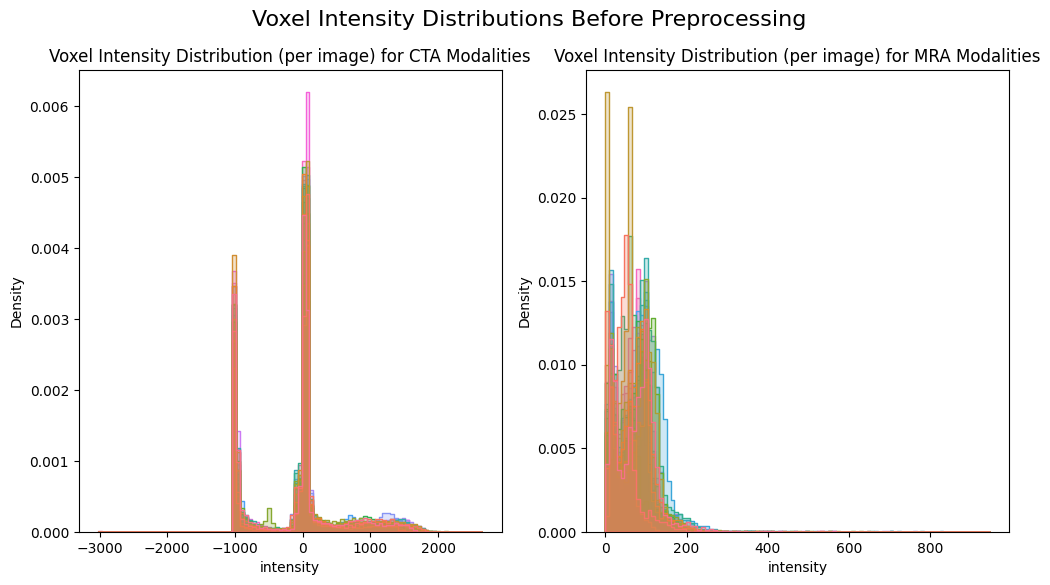

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data=all_distributions_cta_df, x="intensity", hue="image", element="step", bins=100, stat="density", common_norm=False, legend=False, ax=axs[0])
axs[0].set_title('Voxel Intensity Distribution (per image) for CTA Modalities')

sns.histplot(data=all_distributions_mra_df, x="intensity", hue="image", element="step", bins=100, stat="density", common_norm=False, legend=False, ax=axs[1])
axs[1].set_title('Voxel Intensity Distribution (per image) for MRA Modalities')

fig.suptitle('Voxel Intensity Distributions Before Preprocessing', fontsize=16)

plt.show()

# Pixels intensity distribution after preprocessing

## Preprocessing

In [8]:
data_dict = []

for idx, row in df.iterrows():
    data_dict.append({"image": row['file_path'], "label": np.nan, "modality": row['modality']})

class CustomScaleIntensityRanged(MapTransform):
    """Custom intensity scaling transform that applies different scaling methods based on image modality.
    For CT images, it uses ScaleIntensityRanged with fixed intensity bounds.
    For MR images, it uses ScaleIntensityRangePercentilesd to scale based on intensity percentiles."""
    def __init__(self, keys: list, min: float = 0.0, max: float = 1.0):
        super().__init__(keys)
        self.min = min
        self.max = max
        self.ct_transform = ScaleIntensityRanged(
            keys=keys, a_min=-200, a_max=800, b_min=min, b_max=max, clip=True)
        self.mr_transform = ScaleIntensityRangePercentilesd(
            keys=keys, lower=0.5, upper=99.5, b_min=min, b_max=max, 
            clip=True, relative=False, channel_wise=False)

    def __call__(self, data: dict) -> dict:
        d = dict(data)
        if d["modality"] == "ct":
            d = self.ct_transform(d)
        elif d["modality"] == "mr":
            d = self.mr_transform(d)
        else:
            raise ValueError(f"Unsupported modality: {d['modality']}")
        return d

transforms = Compose([
    LoadImaged(keys=["image"]),
    CustomScaleIntensityRanged(keys=["image"], min=0.0, max=1.0)
])

## Visualization

In [9]:
ds = Dataset(data=data_dict, transform=transforms)
loader = DataLoader(ds, batch_size=1, shuffle=False)

all_distributions_cta = []
all_distributions_mra = []
img_plt = []

for idx, data in enumerate(loader):
    img = data['image'][0]  # get the image tensor
    img = img.numpy()  # convert to numpy array

    if idx == 0 or idx == len(loader)-1: # plot the first and last images
        meta = data['image'].meta # get metadata
        img_plt.append([img, meta, data['modality'][0]])
    
    img_flat = img.flatten()  # flatten the array to 1D
    img_flat = np.random.choice(img_flat, size=10000, replace=False)  # sample 10,000 voxels for visualization

    if data['modality'][0] == 'ct':
        all_distributions_cta.append(pd.DataFrame({
            'intensity': img_flat,
            'image': idx
        }))  # append the DataFrame to the list
    elif data['modality'][0] == 'mr':
        all_distributions_mra.append(pd.DataFrame({
            'intensity': img_flat,
            'image': idx
        }))  # append the DataFrame to the list

all_distributions_cta_df = pd.concat(all_distributions_cta, ignore_index=True)
all_distributions_mra_df = pd.concat(all_distributions_mra, ignore_index=True)


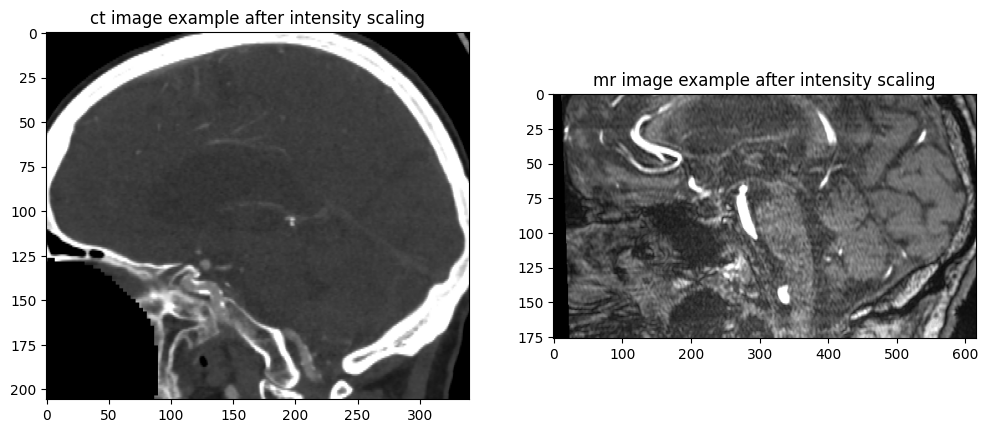

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, data in enumerate(img_plt):
        img = data[0] # get the image array
        meta = data[1] # get metadata

        dx, dy, dz = meta['pixdim'][0, 1:4] # isolate voxel spacing

        slice_idx = img.shape[0] // 2  # middle slice index
        slice_img = img[slice_idx, :, :] # extract the middle slice from x axis

        ny, nz = slice_img.shape # get the shape of the slice ((y, z) of original 3d image)
        extent = [0, ny*dy, 0, nz*dz] # calculate extent in mm to have correct aspect ratio

        axs[i].imshow(np.rot90(slice_img, 1), cmap='gray', aspect=dz/dy)
        axs[i].set_title(f'{data[2]} image example after intensity scaling')

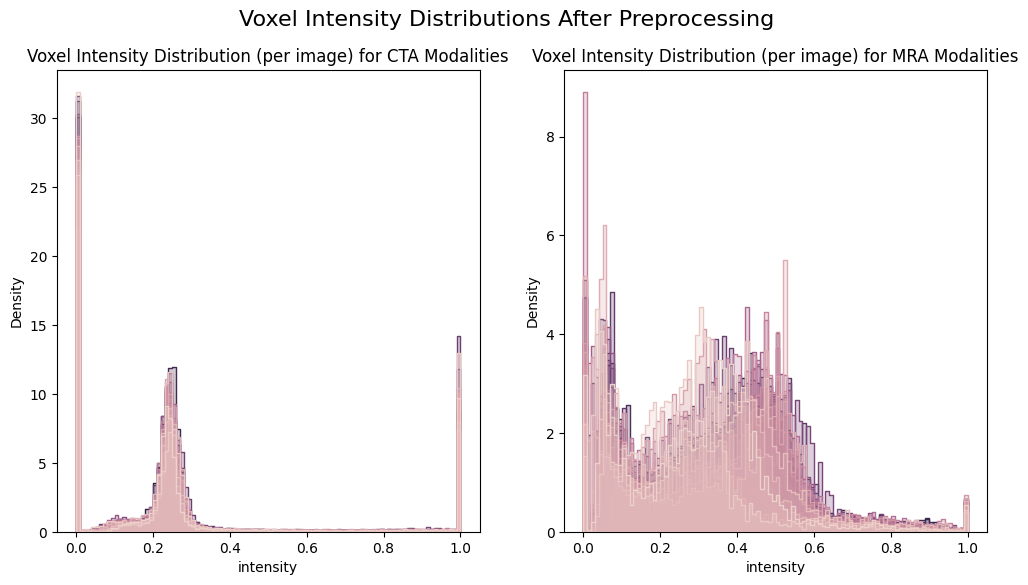

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data=all_distributions_cta_df, x="intensity", hue="image", element="step", bins=100, stat="density", common_norm=False, legend=False, ax=axs[0])
axs[0].set_title('Voxel Intensity Distribution (per image) for CTA Modalities')

sns.histplot(data=all_distributions_mra_df, x="intensity", hue="image", element="step", bins=100, stat="density", common_norm=False, legend=False, ax=axs[1])
axs[1].set_title('Voxel Intensity Distribution (per image) for MRA Modalities')

fig.suptitle('Voxel Intensity Distributions After Preprocessing', fontsize=16)

plt.show()

# Bias Field Correction

In [62]:
class BiasFieldCorrection(MapTransform):
    """Apply N4 Bias Field Correction to the image."""
    def __init__(self, keys: list, shrink_factor: int = 1):
        super().__init__(keys)
        self.shrink_factor = shrink_factor

    def __call__(self, data: dict) -> dict:
        d = dict(data)
        if d.get("modality", None) != "mr":
            return d  # No correction for non-MR images
        
        for key in self.keys:
            print(f"Applying Bias Field Correction for modality: {d['modality']}")
            print(f"Original data type: {type(d[key])}, shape: {d[key].shape}, dtype: {d[key].dtype}")
            t = time.time()
            original_tensor = d[key]
            img = d[key].numpy()  # convert to numpy array
            del_dim = 0
            while len(img.shape) > 3:
                img = np.squeeze(img, axis=0)  # remove singleton dimensions
                del_dim += 1
            img_sitk = sitk.GetImageFromArray(img.astype(np.float32))  # convert to SimpleITK image

            mask = sitk.OtsuThreshold(img_sitk, 0, 1, 200)  # create a mask using Otsu's method

            corrector = sitk.N4BiasFieldCorrectionImageFilter()
            corrector.SetMaximumNumberOfIterations([50,50,30,20])  # set maximum number of iterations for each level

            shrink_factor = self.shrink_factor  # define a shrink factor to speed up processing
            img_shrink = sitk.Shrink(img_sitk, [shrink_factor]*img_sitk.GetDimension())
            mask_shrink = sitk.Shrink(mask, [shrink_factor]*mask.GetDimension())

            corrected_shrink = corrector.Execute(img_shrink, mask_shrink)  # apply N4 bias field correction to shrunken images
            log_bias_field = corrector.GetLogBiasFieldAsImage(img_sitk) # get the log bias field for original image
            img_corrected = img_sitk / sitk.Exp(log_bias_field)  # get the corrected image from original image resolution

            img_corrected = sitk.GetArrayFromImage(img_corrected)  # convert back to numpy array

            while del_dim > 0:
                img_corrected = np.expand_dims(img_corrected, axis=0)  # add back singleton dimensions
                del_dim -= 1

            d[key] = MetaTensor(
                img_corrected,
                meta=original_tensor.meta.copy(),
                dtype=original_tensor.dtype
            ) # Convert back to MetaTensor with original metadata
            d['log_bias_field'] = MetaTensor(
                sitk.GetArrayFromImage(log_bias_field),
                meta=original_tensor.meta.copy()
                )
            d['bias_field_correction_time'] = time.time() - t
            print(f"Corrected data type: {type(d[key])}, shape: {d[key].shape}, dtype: {d[key].dtype}")
            print(f"Time taken for correction: {time.time() - t:.2f} seconds")

        return d

## Test with shrink factor = 2

In [63]:
transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=['image']),
    BiasFieldCorrection(keys=['image'], shrink_factor=2)
])

ds = Dataset(data=data_dict, transform=transforms)
loader = DataLoader(ds, batch_size=1, shuffle=False)

for data1 in loader:
    if data1['modality'][0] == 'mr':
        break

Applying Bias Field Correction for modality: mr
Original data type: <class 'monai.data.meta_tensor.MetaTensor'>, shape: torch.Size([1, 510, 577, 179]), dtype: torch.float32
Corrected data type: <class 'monai.data.meta_tensor.MetaTensor'>, shape: torch.Size([1, 510, 577, 179]), dtype: torch.float32
Time taken for correction: 64.13 seconds


## Test with shrink factor = 4

In [64]:
transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=['image']),
    BiasFieldCorrection(keys=['image'], shrink_factor=4)
])

ds = Dataset(data=data_dict, transform=transforms)
loader = DataLoader(ds, batch_size=1, shuffle=False)

for data2 in loader:
    if data2['modality'][0] == 'mr':
        break

Applying Bias Field Correction for modality: mr
Original data type: <class 'monai.data.meta_tensor.MetaTensor'>, shape: torch.Size([1, 510, 577, 179]), dtype: torch.float32
Corrected data type: <class 'monai.data.meta_tensor.MetaTensor'>, shape: torch.Size([1, 510, 577, 179]), dtype: torch.float32
Time taken for correction: 8.58 seconds


## Test with shrink factor = 8

In [68]:
transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=['image']),
    BiasFieldCorrection(keys=['image'], shrink_factor=8)
])

ds = Dataset(data=data_dict, transform=transforms)
loader = DataLoader(ds, batch_size=1, shuffle=False)

for data3 in loader:
    if data3['modality'][0] == 'mr':
        break

Applying Bias Field Correction for modality: mr
Original data type: <class 'monai.data.meta_tensor.MetaTensor'>, shape: torch.Size([1, 510, 577, 179]), dtype: torch.float32
Corrected data type: <class 'monai.data.meta_tensor.MetaTensor'>, shape: torch.Size([1, 510, 577, 179]), dtype: torch.float32
Time taken for correction: 2.02 seconds


## Visualization

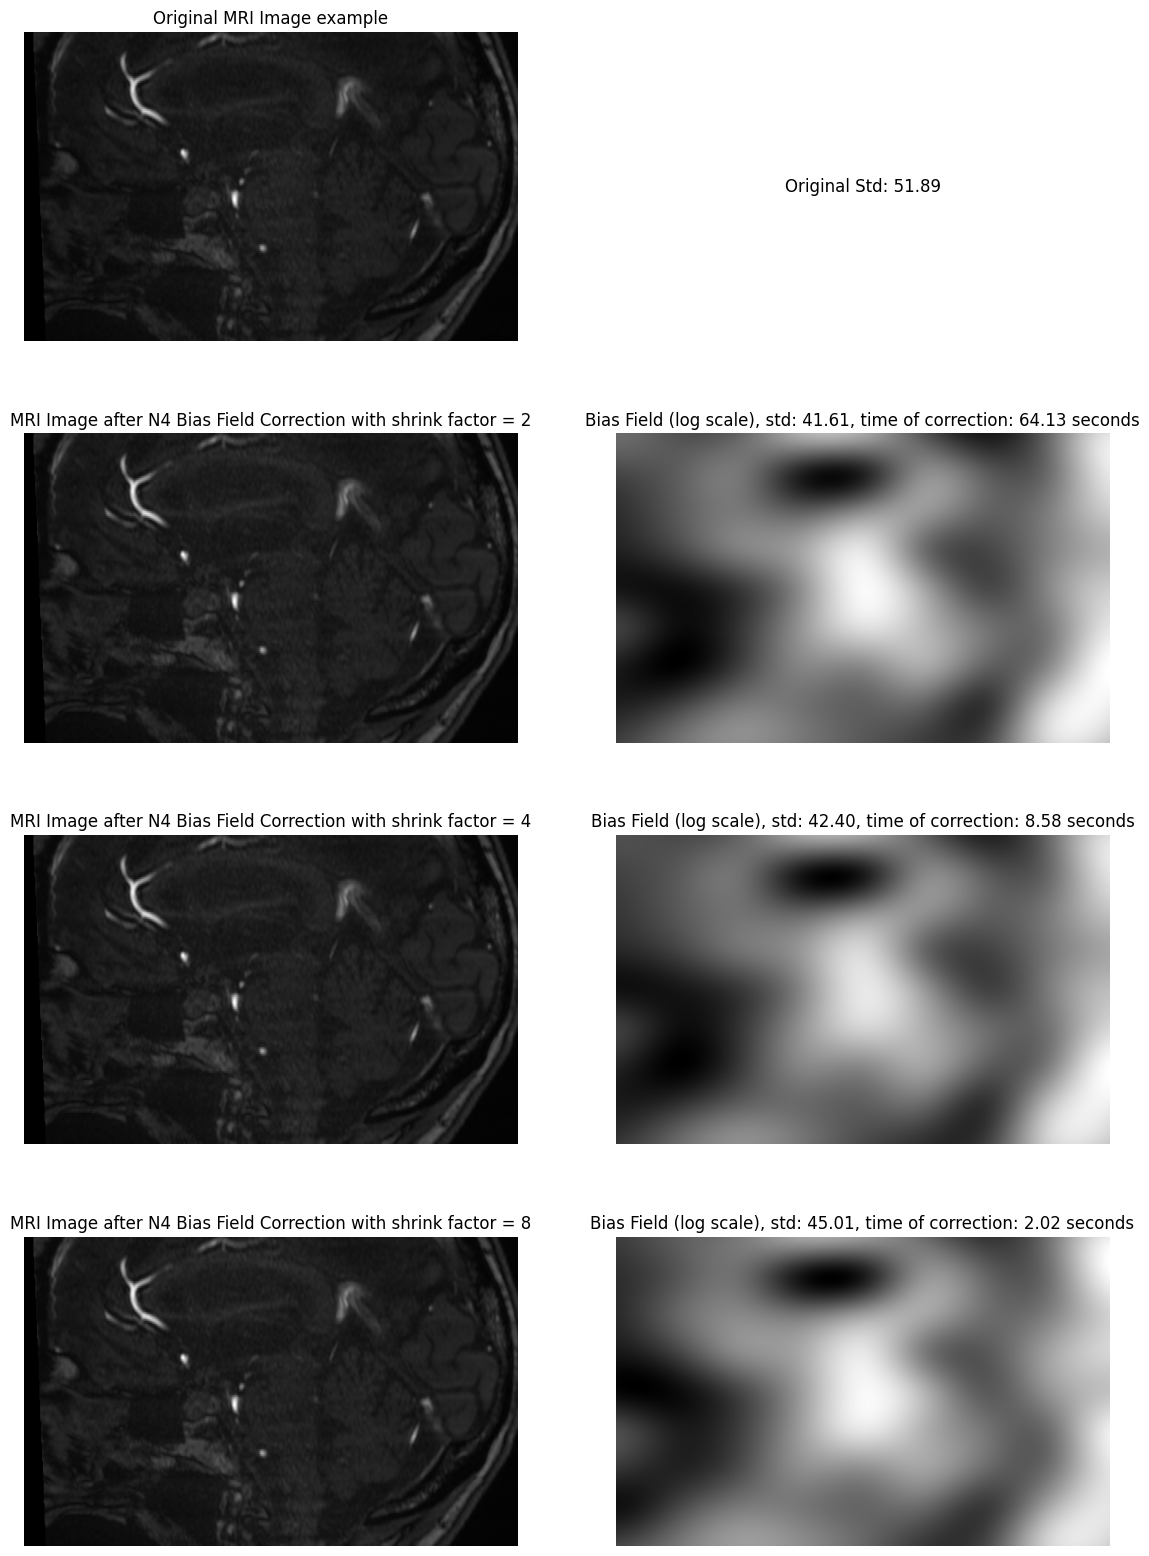

In [69]:
fig, axs = plt.subplots(4, 2, figsize=(14, 20))

# Original image
img = nib.load("../data/raw/imagesTr_topbrain_mr/topcow_mr_003_0000.nii.gz") # load the NIfTI file
meta = img.header # get metadata
img = img.get_fdata() # get the image array

dx, dy, dz = meta['pixdim'][1:4] # isolate voxel spacing

slice_idx = img.shape[0] // 2  # middle slice index
slice_img = img[slice_idx, :, :] # extract the middle slice from x axis

ny, nz = slice_img.shape # get the shape of the slice ((y, z) of original 3d image)
extent = [0, ny*dy, 0, nz*dz] # calculate extent

axs[0, 0].imshow(np.rot90(slice_img, 1), cmap='gray', aspect=dz/dy)
axs[0, 0].set_title(f'Original MRI Image example')
axs[0, 0].axis('off')

axs[0, 1].text(0.5, 0.5, f'Original Std: {slice_img.std():.2f}', horizontalalignment='center', verticalalignment='center', fontsize=12)
axs[0, 1].axis('off')

# Image after N4 Bias Field Correction with shrink factor = 2
img = data1["image"].squeeze() # get the image array
meta = data1["image"].meta # get metadata

img_log_bias = data1["log_bias_field"].squeeze() # get the log bias field array

dx, dy, dz = meta['pixdim'][0, 1:4] # isolate voxel spacing

slice_idx = img.shape[0] // 2  # middle slice index
slice_img = img[slice_idx, :, :] # extract the middle slice from x axis
slice_img_log_bias = img_log_bias[slice_idx, :, :] # extract the middle slice from x axis

ny, nz = slice_img.shape # get the shape of the slice ((y, z) of original 3d image)
extent = [0, ny*dy, 0, nz*dz] # calculate extent in mm to have correct aspect ratio

axs[1, 0].imshow(np.rot90(slice_img, 1), cmap='gray', aspect=dz/dy)
axs[1, 0].set_title(f'MRI Image after N4 Bias Field Correction with shrink factor = 2')
axs[1, 0].axis('off')

axs[1, 1].imshow(np.rot90(slice_img_log_bias, 1), cmap='gray', aspect=dz/dy)
axs[1, 1].set_title(f'Bias Field (log scale), std: {slice_img.std():.2f}, time of correction: {data1["bias_field_correction_time"][0]:.2f} seconds')
axs[1, 1].axis('off')

# Image after N4 Bias Field Correction with shrink factor = 4
img = data2["image"].squeeze() # get the image array
meta = data2["image"].meta # get metadata

img_log_bias = data2["log_bias_field"].squeeze() # get the log bias field array

dx, dy, dz = meta['pixdim'][0, 1:4] # isolate voxel spacing

slice_idx = img.shape[0] // 2  # middle slice index
slice_img = img[slice_idx, :, :] # extract the middle slice from x axis
slice_img_log_bias = img_log_bias[slice_idx, :, :] # extract the middle slice from x axis

ny, nz = slice_img.shape # get the shape of the slice ((y, z) of original 3d image)
extent = [0, ny*dy, 0, nz*dz] # calculate extent in mm to have correct aspect ratio

axs[2, 0].imshow(np.rot90(slice_img, 1), cmap='gray', aspect=dz/dy)
axs[2, 0].set_title(f'MRI Image after N4 Bias Field Correction with shrink factor = 4')
axs[2, 0].axis('off')

axs[2, 1].imshow(np.rot90(slice_img_log_bias, 1), cmap='gray', aspect=dz/dy)
axs[2, 1].set_title(f'Bias Field (log scale), std: {slice_img.std():.2f}, time of correction: {data2["bias_field_correction_time"][0]:.2f} seconds')
axs[2, 1].axis('off')

# Image after N4 Bias Field Correction with shrink factor = 8
img = data3["image"].squeeze() # get the image array
meta = data3["image"].meta # get metadata

img_log_bias = data3["log_bias_field"].squeeze() # get the log bias field array

dx, dy, dz = meta['pixdim'][0, 1:4] # isolate voxel spacing

slice_idx = img.shape[0] // 2  # middle slice index
slice_img = img[slice_idx, :, :] # extract the middle slice from x axis
slice_img_log_bias = img_log_bias[slice_idx, :, :] # extract the middle slice from x axis

ny, nz = slice_img.shape # get the shape of the slice ((y, z) of original 3d image)
extent = [0, ny*dy, 0, nz*dz] # calculate extent in mm to have correct aspect ratio

axs[3, 0].imshow(np.rot90(slice_img, 1), cmap='gray', aspect=dz/dy)
axs[3, 0].set_title(f'MRI Image after N4 Bias Field Correction with shrink factor = 8')
axs[3, 0].axis('off')

axs[3, 1].imshow(np.rot90(slice_img_log_bias, 1), cmap='gray', aspect=dz/dy)
axs[3, 1].set_title(f'Bias Field (log scale), std: {slice_img.std():.2f}, time of correction: {data3["bias_field_correction_time"][0]:.2f} seconds')
axs[3, 1].axis('off')

plt.show()

# Resampling

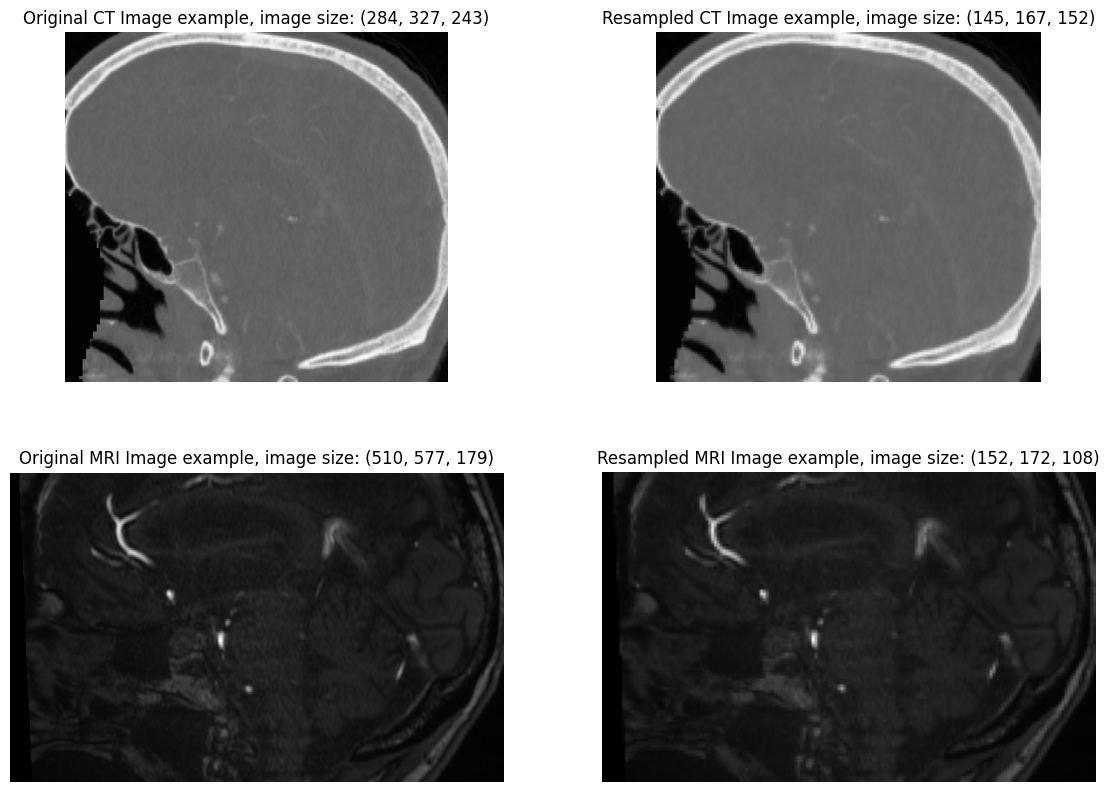

In [84]:
transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=['image']),
    Orientationd(keys=['image'], axcodes="LPS"),
    Spacingd(keys=['image'], pixdim=(1.0, 1.0, 1.0), mode='bilinear')
])

transforms_raw = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=['image']),
    Orientationd(keys=['image'], axcodes="LPS")
])

ds = Dataset(data=data_dict, transform=transforms)
loader = DataLoader(ds, batch_size=1, shuffle=False)

loader_raw = DataLoader(Dataset(data=data_dict, transform=transforms_raw), batch_size=1, shuffle=False)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
for data, data_raw in zip(loader, loader_raw):
    ct_bool = True
    if data['modality'][0] == 'ct' and ct_bool:
        ct_bool = False
        img = data_raw["image"].squeeze() # load the original NIfTI file
        meta = data_raw["image"].meta # get metadata
        img_resamp = data["image"].squeeze() # get the image array

        dx, dy, dz = meta['pixdim'][0, 1:4] # isolate voxel spacing

        slice_idx = img.shape[0] // 2  # middle slice index
        slice_idx_resamp = img_resamp.shape[0] // 2  # middle slice index

        slice_img = img[slice_idx, :, :] # extract the middle slice from x axis
        slice_img_resamp = img_resamp[slice_idx_resamp, :, :] # extract the middle slice from x axis

        ny, nz = slice_img.shape # get the shape of the slice ((y, z) of original 3d image)
        extent = [0, ny*dy, 0, nz*dz] # calculate extent

        axs[0, 0].imshow(np.rot90(slice_img, 1), cmap='gray', aspect=dz/dy)
        axs[0, 0].set_title(f'Original CT Image example, image size: {img.numpy().shape}')
        axs[0, 0].axis('off')

        axs[0, 1].imshow(np.rot90(slice_img_resamp, 1), cmap='gray')
        axs[0, 1].set_title(f'Resampled CT Image example, image size: {img_resamp.numpy().shape}')
        axs[0, 1].axis('off')
        
    if data['modality'][0] == 'mr':
        img = data_raw["image"].squeeze() # load the original NIfTI file
        meta = data_raw["image"].meta # get metadata
        img_resamp = data["image"].squeeze() # get the image array

        dx, dy, dz = meta['pixdim'][0, 1:4] # isolate voxel spacing

        slice_idx = img.shape[0] // 2  # middle slice index
        slice_idx_resamp = img_resamp.shape[0] // 2  # middle slice index

        slice_img = img[slice_idx, :, :] # extract the middle slice from x axis
        slice_img_resamp = img_resamp[slice_idx_resamp, :, :] # extract the middle slice from x axis

        ny, nz = slice_img.shape # get the shape of the slice ((y, z) of original 3d image)
        extent = [0, ny*dy, 0, nz*dz] # calculate extent

        axs[1, 0].imshow(np.rot90(slice_img, 1), cmap='gray', aspect=dz/dy)
        axs[1, 0].set_title(f'Original MRI Image example, image size: {img.numpy().shape}')
        axs[1, 0].axis('off')

        axs[1, 1].imshow(np.rot90(slice_img_resamp, 1), cmap='gray')
        axs[1, 1].set_title(f'Resampled MRI Image example, image size: {img_resamp.numpy().shape}')
        axs[1, 1].axis('off')
        break
plt.show()


In [85]:
meta

{'srow_x': tensor([[-2.9476e-01,  2.5788e-02,  4.8928e-02,  6.1315e+01]]),
 'quatern_d': tensor([-0.9982]),
 'intent_p2': tensor([0.]),
 'glmax': tensor([0], dtype=torch.int32),
 'srow_y': tensor([[-2.5736e-02, -2.9575e-01,  3.4169e-03,  5.7065e+01]]),
 'xyzt_units': tensor([10], dtype=torch.uint8),
 original_channel_dim: tensor([nan], dtype=torch.float64),
 'intent_p1': tensor([0.]),
 'slice_duration': tensor([0.]),
 'srow_z': tensor([[ 2.4264e-02, -4.2009e-04,  5.9799e-01, -5.0125e+01]]),
 'scl_inter': tensor([nan]),
 'extents': tensor([0], dtype=torch.int32),
 'slice_code': tensor([0], dtype=torch.uint8),
 'qform_code': tensor([0], dtype=torch.int16),
 'quatern_b': tensor([-0.0409]),
 'dim_info': tensor([54], dtype=torch.uint8),
 space: [RAS],
 'slice_end': tensor([0], dtype=torch.int16),
 'glmin': tensor([0], dtype=torch.int32),
 spatial_shape: tensor([[510, 577, 179]], dtype=torch.int16),
 'qoffset_z': tensor([-50.1245]),
 'cal_max': tensor([0.]),
 'qoffset_y': tensor([57.0647]),
